In [ ]:
import numpy as np
import pandas as pd
import pennylane as qml
from susy_qm import calculate_Hamiltonian
from qiskit.quantum_info import SparsePauliOp
import itertools

from qutip import Qobj, concurrence, ptrace

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [94]:
potential = 'QHO'
cutoffs = [2, 4, 8, 16, 32, 64, 128]

# 9 qubits for 256
data = {}
data_qu = int(np.log2(max(cutoffs))) + 1
for qubit1 in range(1, data_qu):
        for qubit2 in range(qubit1 + 1, data_qu):
                data[f"q{qubit1}{qubit2}"] = []


for cutoff in cutoffs:

    print(f"Running for cutoff: {cutoff}")

    #calculate Hamiltonian and expected eigenvalues
    H = calculate_Hamiltonian(cutoff, potential)

    eigenvalues, eigenvectors = np.linalg.eig(H)
    min_index = np.argmin(eigenvalues)
    min_eigenvalue = eigenvalues[min_index]
    min_eigenvector = np.asarray(eigenvectors[:, min_index])

    hamiltonian = SparsePauliOp.from_operator(H)
    num_qubits = hamiltonian.num_qubits

    psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
    rho = psi * psi.dag()

    cutoff_qubits = []
    for qubit1 in range(1, num_qubits):
        for qubit2 in range(qubit1 + 1, num_qubits):
            
            rho_2q = ptrace(rho, [qubit1, qubit2])
            c = concurrence(rho_2q)

            col_name = f"q{qubit1}{qubit2}"
            data[col_name].append(c)

            cutoff_qubits.append(col_name)

    nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
    for key in nan_qubits:
        data[key].append(np.nan)

data['cutoffs'] = cutoffs.copy()
#data           

Running for cutoff: 2
Running for cutoff: 4
Running for cutoff: 8
Running for cutoff: 16
Running for cutoff: 32
Running for cutoff: 64
Running for cutoff: 128


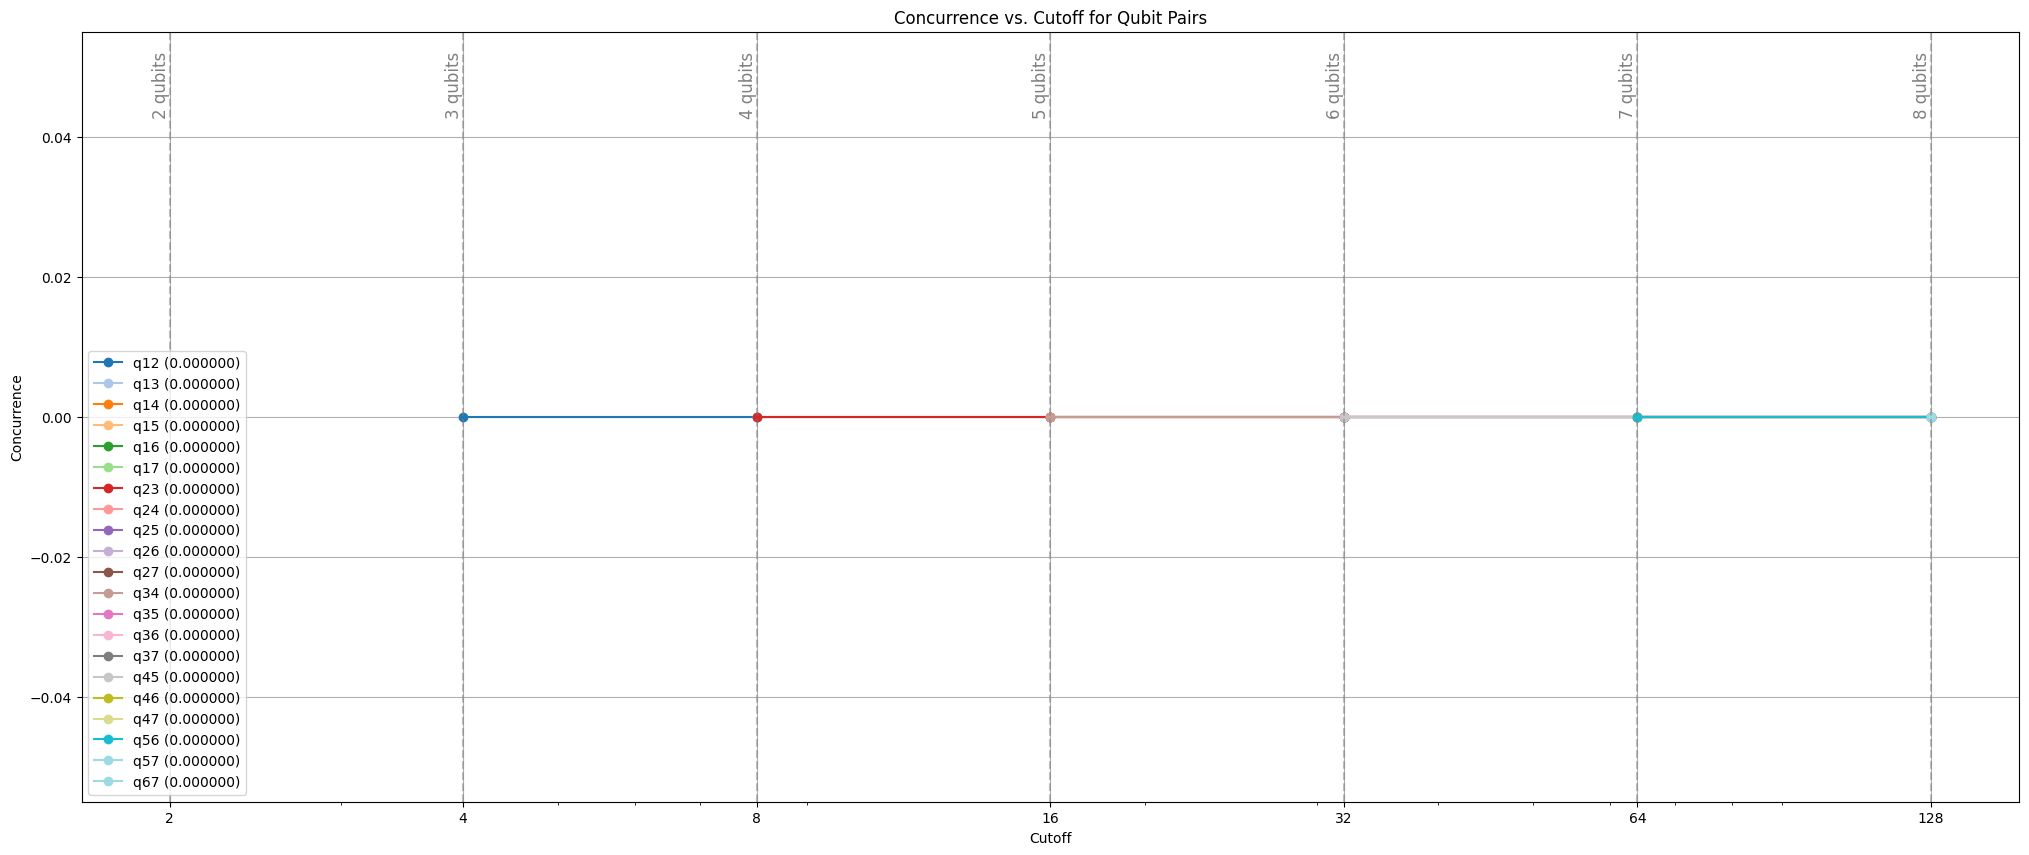

In [95]:
num_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

plt.figure(figsize=(25,10))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key} ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Concurrence")
plt.title("Concurrence vs. Cutoff for Qubit Pairs")
plt.legend()
plt.grid()
#plt.show()
plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\ConcurrencePlots\plot_{}".format(potential))

In [ ]:
potential = 'DW'
cutoff = 256

In [ ]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cutoff, potential)

eigenvalues, eigenvectors = np.linalg.eig(H)
min_index = np.argmin(eigenvalues)
min_eigenvalue = eigenvalues[min_index]
min_eigenvector = np.asarray(eigenvectors[:, min_index])

min_3_ev = eigenvalues.argsort()[:3]

hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [14]:
# Convert state vector to a QuTiP object
# dims = [[2,2,2,2],[1,1,1,1]] means: 4 qubits in the ket, each dimension = 2
psi_qobj = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])

# Build the density matrix rho = |psi><psi|
rho_qobj = psi_qobj * psi_qobj.dag()

# Loop over all distinct 2-qubit pairs
for qubit1 in range(num_qubits):
    for qubit2 in range(qubit1 + 1, num_qubits):
        # Partial trace over all qubits EXCEPT qubit1, qubit2
        # 'ptrace' takes a list of which subsystem indices to keep
        rho_2q = ptrace(rho_qobj, [qubit1, qubit2])
        
        # Compute the concurrence (a 2-qubit entanglement measure)
        c = concurrence(rho_2q)
        
        print(f"Concurrence between qubit {qubit1} and {qubit2} = {c:.6f}")


Concurrence between qubit 0 and 1 = 0.000000
Concurrence between qubit 0 and 2 = 0.000000
Concurrence between qubit 1 and 2 = 0.052899
